## Notebook to run post processing of differential expression in single-cell data using glmmTMB for the replication cohort data

basically 
- read glmmTMB r script results per region and cell-type and then integrate them
- apply B&H FDR 
- take a look at overlap between brain regions and cell-types do some sample plotting
- this is a reduced copy of the discovery cohort post processing

In [1]:
!date

Wed Jan  3 22:01:48 UTC 2024


#### import libraries

In [2]:
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import json
from os.path import exists

import warnings
warnings.simplefilter('ignore')

import random
random.seed(420)

#### set notebook variables

In [3]:
# parameters
project = 'aging_phase1'
set_name = f'{project}_replication'
cohort = 'aging'

# directories for initial setup
wrk_dir = '/home/jupyter/brain_aging_phase1'
replication_dir = f'{wrk_dir}/replication'

# in files
anndata_file = f'{replication_dir}/{set_name}.full.h5ad'
temp_name_remap_json = '{this_dir}/{name}_gene_name_remap_temp.csv'
temp_r_out_file = '{this_dir}/{chrt}.{name}_glmmtmb_results_temp.csv'

# out files
results_file = f'{replication_dir}/{set_name}.glmmtmb_age_diffs.csv'
results_fdr_file = f'{replication_dir}/{set_name}.glmmtmb_age_diffs_fdr.csv'

# constants
DEBUG = True
min_cell_count = 3
young_age_limit = 30.0


sns.set_theme(style='white', palette='Paired', font_scale=1.2)

# allow for more rows in output
prev_default = pd.get_option('max_rows')
pd.set_option('max_rows', 2000)    
# # restore default setting
# pd.set_option('max_rows',prev_default)

#### analysis functions

In [4]:
def read_feature_renamed_map(group_name: str) -> dict:
    # read dict from json file
    rename_cols = json.load(open(temp_name_remap_json.format(this_dir=replication_dir,
                                                             name=group_name.replace(" ", "_"))))
    return rename_cols

def reformat_glmmtmb_df(df: pd.DataFrame) -> pd.DataFrame:
    # reformat results into one row per feature
    temp_term = df.loc[df['term'] == 'old'].copy()
    temp_intercepts = df.loc[df['term'] == '(Intercept)', ['feature', 'estimate']].copy()
    temp_intercepts = temp_intercepts.rename(columns={'estimate': 'intercept'})
    this_df = temp_term.merge(temp_intercepts, how='inner', on='feature')
    return this_df[['feature', 'intercept', 'estimate', 'std.error', 'statistic', 'p.value']]

def read_glmmtmb_results(group_name: str, group_type: str, cols_to_rename: dict) -> pd.DataFrame:
    this_file = temp_r_out_file.format(this_dir=replication_dir, chrt=cohort, 
                                       name=group_name.replace(" ", "_"))
    if exists(this_file):
        this_df = pd.read_csv(this_file)
        # need to flip the features with '-' -> '_' for R back to originals
        # the the key/values
        rename_cols = {value: key for (key, value) in cols_to_rename.items()}
        this_df['feature'] = this_df['feature'].replace(rename_cols)
        this_df = reformat_glmmtmb_df(this_df)
        this_df['tissue'] = group_name
        this_df['type'] = group_type     
    else:
        this_df = None
    return this_df

def compute_bh_fdr(df: pd.DataFrame, alpha: float=0.05, p_col: str='p.value',
                   method: str='fdr_bh', verbose: bool=True) -> pd.DataFrame:
    ret_df = df.copy()
    test_adjust = multipletests(np.array(ret_df[p_col]), alpha=alpha, 
                                method=method)
    ret_df[method] = test_adjust[1]
    if verbose:
        print(f'total significant after correction: {ret_df.loc[ret_df[method] < alpha].shape}')
    return ret_df

def plot_feature_by_age_group(df: pd.DataFrame, x_term: str, y_term: str):
    plt.figure(figsize=(9,9))
    sns.boxenplot(x=x_term,y=y_term, scale='exponential', data=df,
                  k_depth='trustworthy')

    grsplt = sns.stripplot(x=x_term,y=y_term, data=df, alpha=0.75,
                           jitter=True, color='darkgrey')
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel(x_term)
    plt.ylabel(y_term)
    plt.show()
    
def plot_feature_by_sample(df: pd.DataFrame, x_term: str, y_term: str):
    # set up order by young then old
    temp = df.groupby('Age_group')['Sample_ID'].unique()
    this_list = temp['young'].to_list() + temp['old'].to_list()    
    plt.figure(figsize=(9,9))
    sns.boxenplot(x='Sample_ID',y=y_term, scale='exponential', data=df,
                  k_depth='trustworthy', hue=x_term, order=this_list)
    grsplt = sns.stripplot(x='Sample_ID',y=y_term, data=df, alpha=0.75,
                           jitter=True, color='darkgrey', order=this_list)
    plt.xticks(rotation=75)
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel('Sample')
    plt.ylabel(y_term)
    plt.show()    
    
def volcano_plot(df: pd.DataFrame, x_term: str='estimate', y_term: str='p.value', 
                 alpha: float=0.05, adj_p_col: str='fdr_bh', title: str=None, 
                 filter_nseeff: bool=True, extreme_size: float=10.0):
    if filter_nseeff:
        df = df.loc[((-extreme_size < df[x_term]) & 
                    (df[x_term] < extreme_size) &
                    (~df['statistic'].isna()) | 
                    (df[adj_p_col] < alpha))]
    plt.figure(figsize=(9,9))
    log_pvalue = -np.log10(df[y_term])
    is_sig = df[adj_p_col] < alpha
    sns.scatterplot(x=x_term, y=log_pvalue, data=df, hue=is_sig)
    plt.title(title)
    plt.xlabel('effect')
    plt.ylabel('-log10(p-value)')
    plt.show()
    
def prep_plot_feature(data: AnnData, feature_results: pd.Series, 
                      group: str='old', filter_zeros: bool=False):
    this_ad = subset_ad_by_type(data, feature_results.tissue, feature_results.type)
    this_df = convert_ad_to_df(this_ad)
    if filter_zeros:
        this_df = this_df.loc[this_df[feature_results.feature] > 0]
    print(feature_results)
    sns.set_theme(style='white', palette='Paired', font_scale=1.2)
    plot_feature_by_age_group(this_df, group, feature_results.feature)
    plot_feature_by_sample(this_df, group, feature_results.feature)
    
def subset_ad_by_type(data: AnnData, group_name: str, type_name: str,
                      reapply_filter: bool=True, min_cell_count: int=3,
                      verbose: bool=False) -> AnnData:
    name_parts = group_name.split(' ')
    broad_cell_name = name_parts[len(name_parts)-1]
    this_data = data[data.obs.Cell_type == broad_cell_name].copy()
    shape_before = this_data.shape
    if reapply_filter:
        sc.pp.filter_genes(this_data, min_counts=min_cell_count)
        sc.pp.filter_cells(this_data, min_counts=min_cell_count)
        shape_after = this_data.shape
    if verbose:
        print(f'shape before and after: {shape_before} {shape_after}')
        print(this_data)
    return this_data

def convert_ad_to_df(data: AnnData, young_age_limit: float=30.0, 
                     verbose: bool=False) -> pd.DataFrame:
    data_df = data.to_df()
    annots = data.obs[['Brain_region', 'Age', 
                       'Sample_ID', 'Sex']].copy()
    annots['old'] = np.where((annots['Age'] > young_age_limit), 1, 0)
    annots['Age_group'] = np.where((annots['Age'] > young_age_limit), 'old', 'young')
    annots['female'] = np.where((annots['Sex'] == 'Female'), 1, 0)
    this_df = None
    if data_df.index.equals(annots.index):
        this_df = pd.concat([data_df, annots], axis='columns')
        if verbose:
            print(this_df.shape)
            display(this_df.head())
    return this_df

#### read the anndata (h5ad) file

In [5]:
%%time
adata = sc.read(anndata_file, cache=True)
print(adata)

AnnData object with n_obs × n_vars = 74291 × 21374
    obs: 'Sample_ID', 'Sex', 'Age', 'Barcode', 'Study', 'Study_type', 'Batch', 'Cluster', 'Cell_type', 'Brain_region', 'leiden_scVI'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Cell_type_colors', 'Cluster_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
CPU times: user 568 ms, sys: 1.25 s, total: 1.82 s
Wall time: 1.81 s


#### take a look at the cell counts by cell type
only single region and broad cell-types

In [6]:
display(adata.obs.Cluster.value_counts())
display(adata.obs.Cell_type.value_counts())

SFG:Oligo.2    25679
SFG:Exc.3       6441
SFG:Exc.4       5887
SFG:Astro.1     4814
SFG:Micro       4098
SFG:OPC         3154
ODC7            2940
SFG:Exc.2       2681
SFG:Exc.1       2366
SFG:Exc.5       2320
SFG:Exc.6       2243
SFG:Inh.2       2234
SFG:Inh.1       2089
SFG:Inh.3       1991
ASC2            1895
SFG:Endo        1293
SFG:Inh.4       1179
ODC5             472
PER.END1         185
INH4             170
SFG:Exc.7        137
EC:Exc.4          18
Name: Cluster, dtype: int64

Oligo    29091
ExN      22157
InN       7663
Astro     6645
Micro     4098
OPC       3154
Endo      1478
Name: Cell_type, dtype: int64

#### get sample counts per age group by counts by cell-type

In [7]:
adata.obs['old'] = np.where((adata.obs['Age'] > young_age_limit), 1, 0)
adata.obs['female'] = np.where((adata.obs['Sex'] == 'Female'), 1, 0)
display(adata.obs.groupby(['Cell_type','old'])['Sample_ID'].nunique())

Cell_type  old
ExN        0      5
           1      7
OPC        0      5
           1      7
Oligo      0      5
           1      7
Micro      0      5
           1      7
Endo       0      5
           1      7
InN        0      5
           1      7
Astro      0      5
           1      7
Name: Sample_ID, dtype: int64

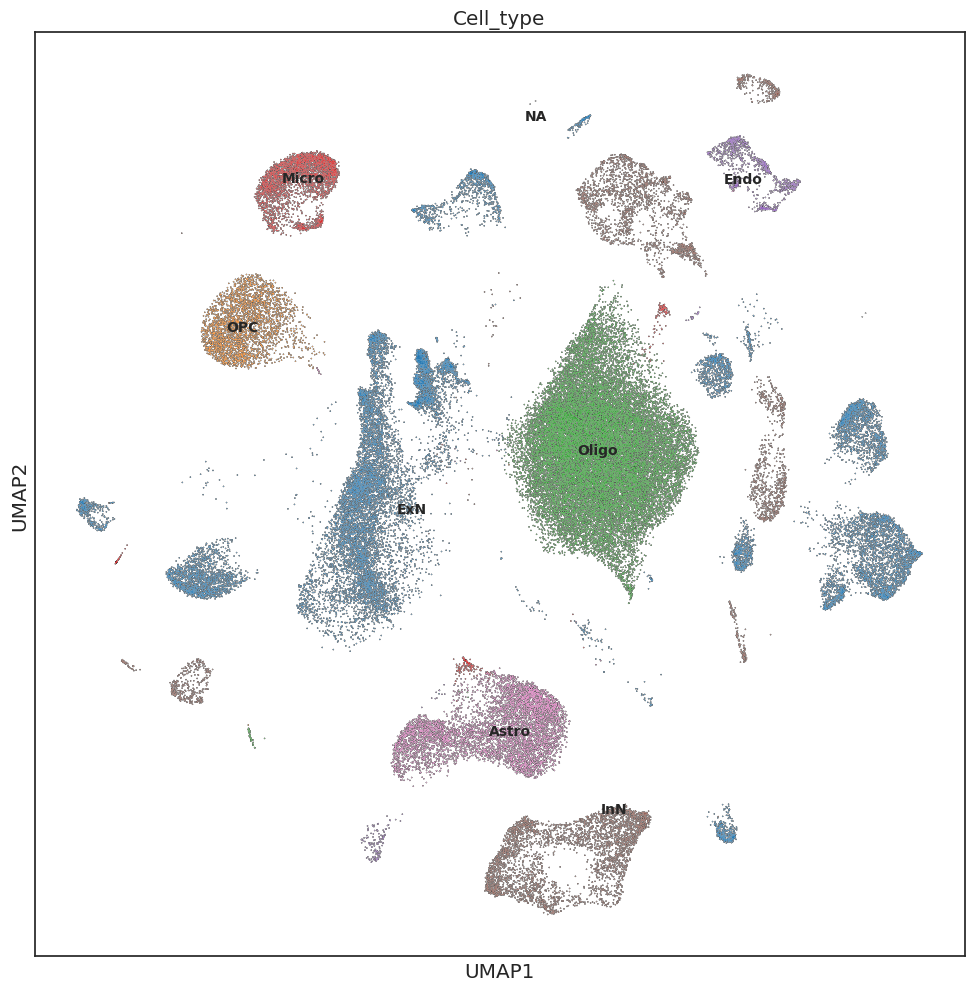

In [8]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=['Cell_type'], legend_loc='on data', 
               add_outline=True, legend_fontsize=10)

##### find cell-types not used in analysis
remove them, and then refilter genes based on cell count

In [9]:
adata = adata[~adata.obs.Cell_type.isna(), :]
sc.pp.filter_genes(adata, min_cells=min_cell_count)
print(adata)

AnnData object with n_obs × n_vars = 74286 × 21370
    obs: 'Sample_ID', 'Sex', 'Age', 'Barcode', 'Study', 'Study_type', 'Batch', 'Cluster', 'Cell_type', 'Brain_region', 'leiden_scVI', 'old', 'female'
    var: 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells'
    uns: 'Cell_type_colors', 'Cluster_colors', 'hvg', 'leiden', 'leiden_scVI_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'


### read the diff by age results by region and cell-type

In [10]:
%%time
glmmtmb_results = None
this_type = 'region_broad_celltype'
for region in adata.obs.Brain_region.unique():
    for broad_type in adata.obs.Cell_type.unique():
        this_tissue = f'{region.capitalize()} {broad_type}'
        print(this_tissue)
        renamed_features = read_feature_renamed_map(this_tissue)
        glmmtmb_results = pd.concat([glmmtmb_results, 
                                     read_glmmtmb_results(this_tissue, this_type,
                                                          renamed_features)])

Frontal cortex Astro
Frontal cortex InN
Frontal cortex Oligo
Frontal cortex ExN
Frontal cortex Micro
Frontal cortex OPC
Frontal cortex Endo
CPU times: user 2.09 s, sys: 53.8 ms, total: 2.14 s
Wall time: 2.13 s


In [11]:
if DEBUG:
    print(glmmtmb_results.shape)
    display(glmmtmb_results.sample(5))

(56736, 8)


,feature,intercept,estimate,std.error,statistic,p.value,tissue,type
10315,GCAT,-4.095892,0.072380,0.209574,0.345366,0.729819,Frontal cortex Oligo,region_broad_celltype
2646,IGFBP5,-3.065392,0.137430,0.214050,0.642046,0.520843,Frontal cortex InN,region_broad_celltype
1695,USP34,0.107163,0.137246,0.124067,1.106220,0.268631,Frontal cortex ExN,region_broad_celltype
9491,CDC26,-3.326667,-0.113597,0.155072,-0.732546,0.463835,Frontal cortex Oligo,region_broad_celltype
12938,TARBP1,-0.048076,-0.150804,0.074344,-2.028455,0.042514,Frontal cortex InN,region_broad_celltype


#### count of glmmTMB results by type

In [12]:
display(glmmtmb_results.groupby('type')['tissue'].value_counts())

type                   tissue              
region_broad_celltype  Frontal cortex ExN      13566
                       Frontal cortex InN      13395
                       Frontal cortex Oligo    10905
                       Frontal cortex Astro     8068
                       Frontal cortex OPC       5392
                       Frontal cortex Micro     4291
                       Frontal cortex Endo      1119
Name: tissue, dtype: int64

#### compute the FDR values

In [13]:
glmmtmb_results['p.value'] = glmmtmb_results['p.value'].fillna(1)
glmmtmb_results = compute_bh_fdr(glmmtmb_results)
print(glmmtmb_results.shape)
if DEBUG:
    display(glmmtmb_results.sort_values('fdr_bh').head())

total significant after correction: (971, 9)
(56736, 9)


,feature,intercept,estimate,std.error,statistic,p.value,tissue,type,fdr_bh
7637,PDCD10,-1.197682,-0.389955,0.042263,-9.226864,2.786704e-20,Frontal cortex InN,region_broad_celltype,1.581064e-15
2902,ATG5,-0.377386,-0.229982,0.028983,-7.934947,2.105856e-15,Frontal cortex InN,region_broad_celltype,5.973893e-11
12356,DIS3L2,-0.328009,-0.200831,0.027809,-7.221754,5.132110e-13,Frontal cortex InN,region_broad_celltype,7.572406e-09
12259,C8orf34,-0.618901,-0.498038,0.069015,-7.216387,5.338695e-13,Frontal cortex ExN,region_broad_celltype,7.572406e-09
11774,NBN,-1.157617,-0.294928,0.041283,-7.143993,9.065797e-13,Frontal cortex InN,region_broad_celltype,1.028714e-08


#### count of significant genes by type for glmmTMB

In [14]:
display(glmmtmb_results.loc[glmmtmb_results['fdr_bh'] < 0.05].groupby('type')['tissue'].value_counts())

type                   tissue              
region_broad_celltype  Frontal cortex InN      517
                       Frontal cortex OPC      133
                       Frontal cortex ExN      123
                       Frontal cortex Oligo     88
                       Frontal cortex Astro     56
                       Frontal cortex Micro     44
                       Frontal cortex Endo      10
Name: tissue, dtype: int64

### save the full results

In [15]:
glmmtmb_results.to_csv(results_file, index=False)

### save the statistically significant results

In [16]:
glmmtmb_results.loc[glmmtmb_results['fdr_bh'] < 0.05].to_csv(results_fdr_file, index=False)

In [17]:
if DEBUG:
    display(glmmtmb_results.loc[glmmtmb_results['fdr_bh'] < 0.05].head())

,feature,intercept,estimate,std.error,statistic,p.value,tissue,type,fdr_bh
94,SQLE,-1.940540,-0.720107,0.171606,-4.196275,0.000027,Frontal cortex Astro,region_broad_celltype,0.005031
202,INSIG1,-0.929340,-0.940493,0.208087,-4.519703,0.000006,Frontal cortex Astro,region_broad_celltype,0.001872
384,IL1RAP,-4.215855,0.871074,0.230632,3.776905,0.000159,Frontal cortex Astro,region_broad_celltype,0.017459
521,EFCAB2,-1.135872,0.270343,0.078059,3.463337,0.000534,Frontal cortex Astro,region_broad_celltype,0.037095
556,DNAH12,-2.939941,0.561260,0.149423,3.756189,0.000173,Frontal cortex Astro,region_broad_celltype,0.018393


### visualize volcano plots

---- all glmmTMB results ----


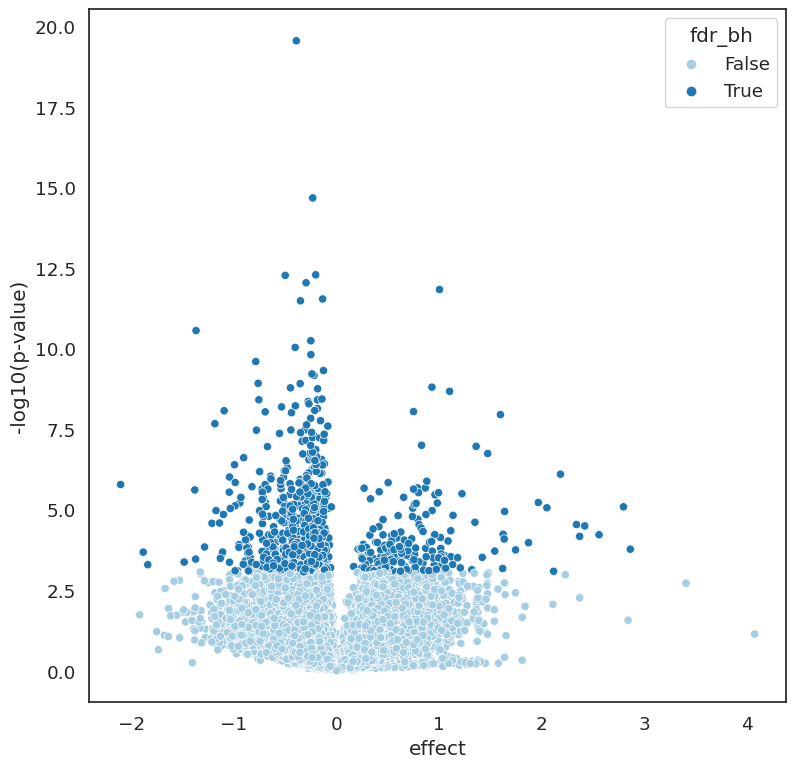

---- per region broad cell-type glmmTMB results ----
*** Frontal cortex Astro glmmTMB results ***


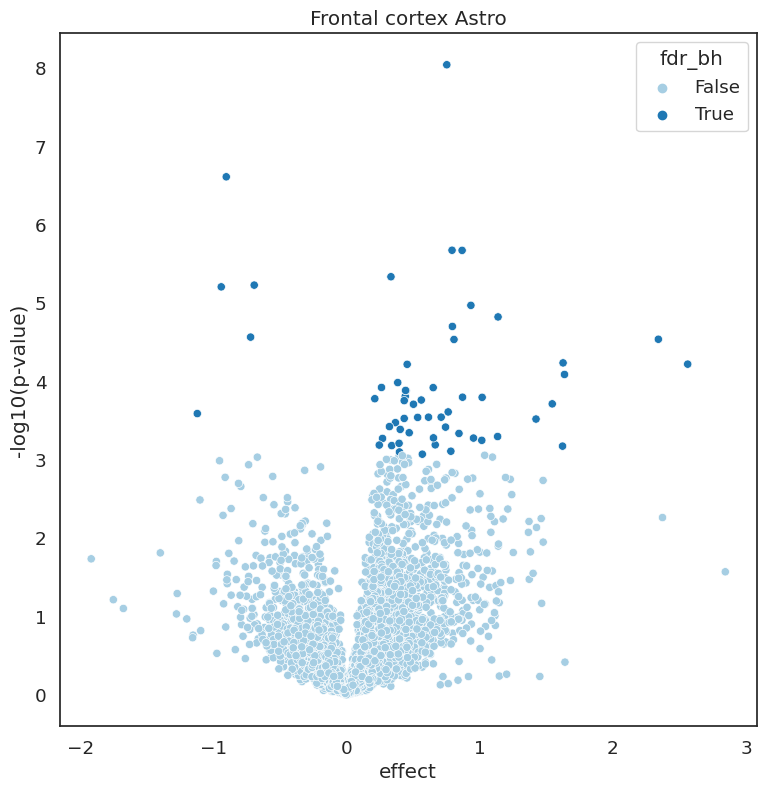

*** Frontal cortex InN glmmTMB results ***


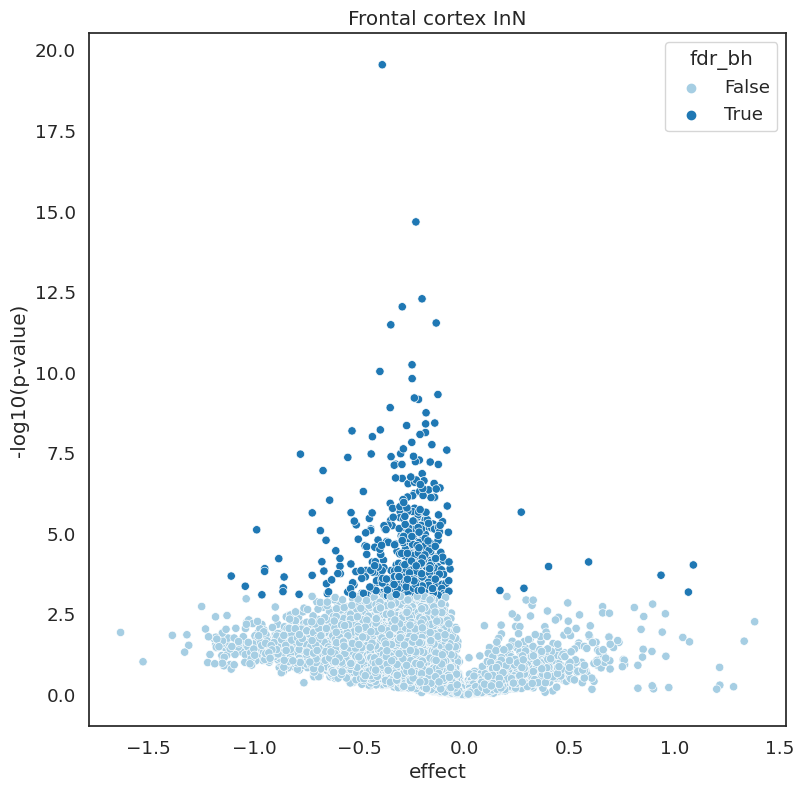

*** Frontal cortex Oligo glmmTMB results ***


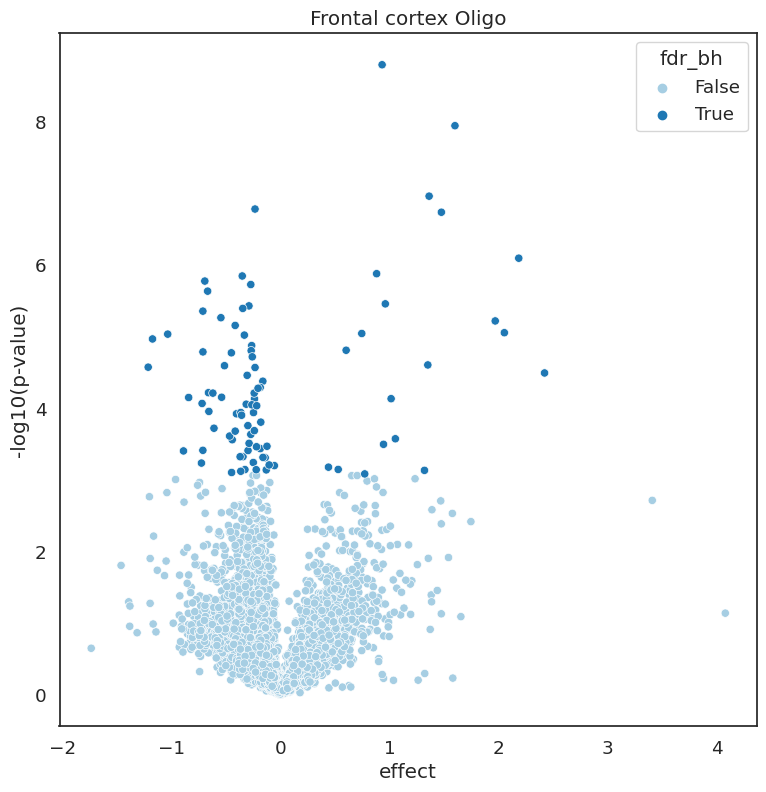

*** Frontal cortex ExN glmmTMB results ***


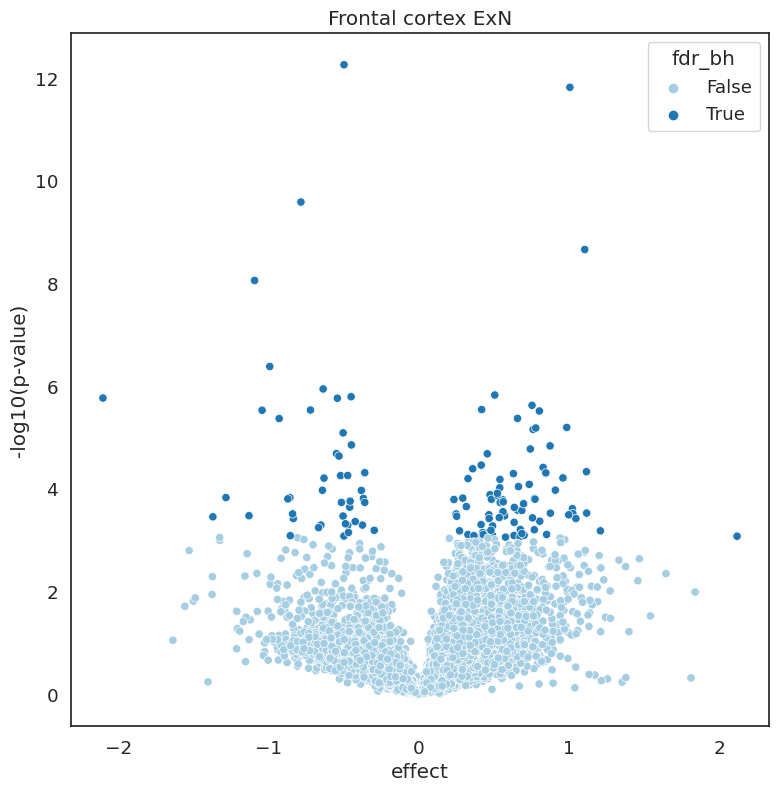

*** Frontal cortex Micro glmmTMB results ***


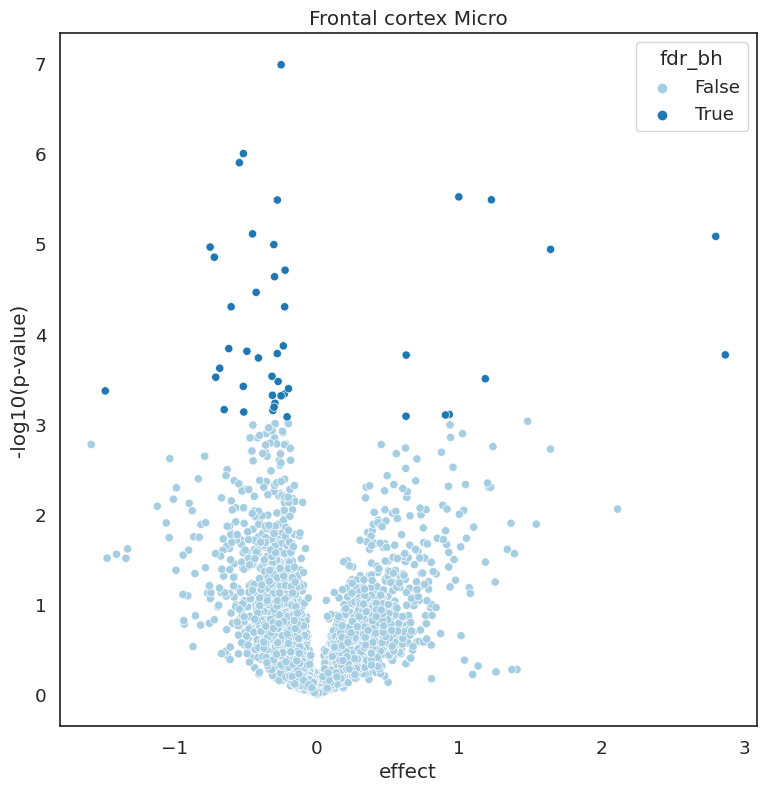

*** Frontal cortex OPC glmmTMB results ***


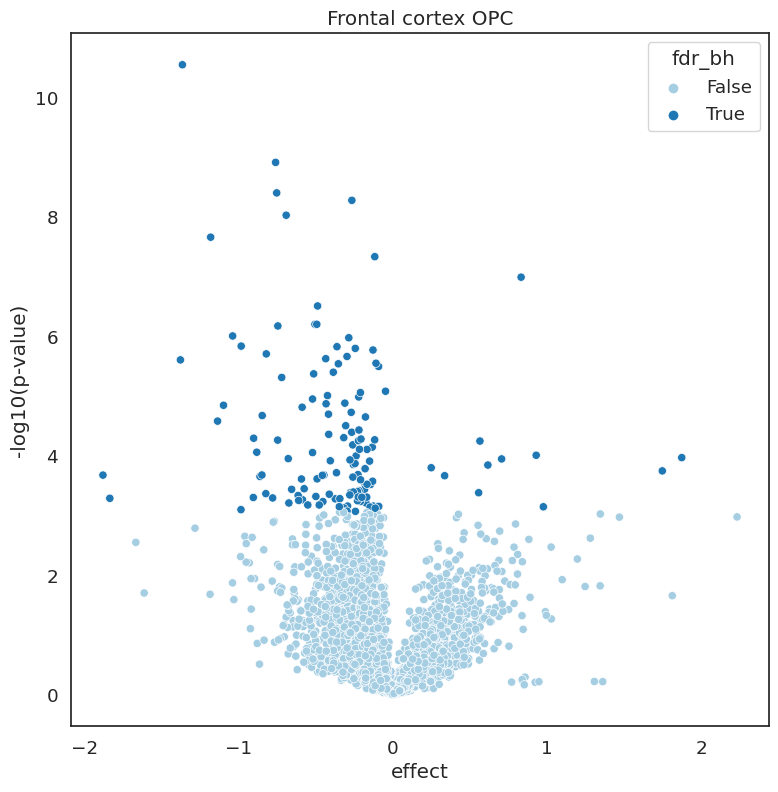

*** Frontal cortex Endo glmmTMB results ***


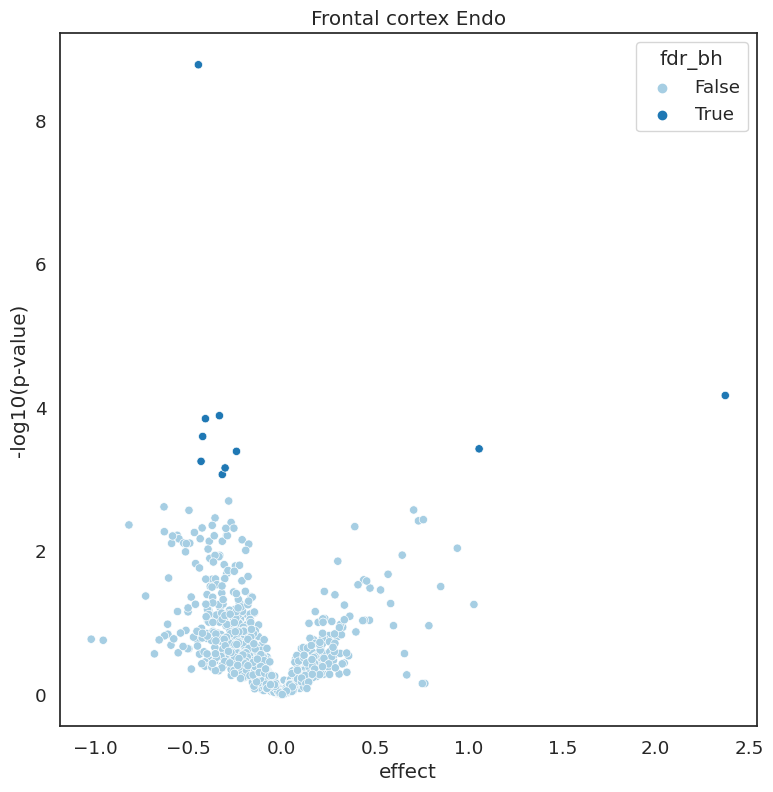

In [18]:
print('---- all glmmTMB results ----')
volcano_plot(glmmtmb_results)

print('---- per region broad cell-type glmmTMB results ----')
for tissue in glmmtmb_results['tissue'].unique():
    print(f'*** {tissue} glmmTMB results ***')
    volcano_plot(glmmtmb_results.loc[glmmtmb_results['tissue'] == tissue], title=tissue)

In [19]:
if DEBUG:
    display(glmmtmb_results.sample(10))

,feature,intercept,estimate,std.error,statistic,p.value,tissue,type,fdr_bh
6590,YJEFN3,-1.573490,-0.370736,0.368843,-1.005133,0.314833,Frontal cortex ExN,region_broad_celltype,0.696959
4492,CCDC117,-3.076945,-0.203092,0.284127,-0.714796,0.474735,Frontal cortex Astro,region_broad_celltype,0.797631
8976,IGSF11-AS1,-6.035117,0.069367,0.490115,0.141532,0.887450,Frontal cortex ExN,region_broad_celltype,0.969847
2031,TGFB1,-3.450537,0.060410,0.153907,0.392511,0.694681,Frontal cortex InN,region_broad_celltype,0.902632
6151,DDIT4,-1.350584,-0.411411,0.402513,-1.022107,0.306730,Frontal cortex Astro,region_broad_celltype,0.691436
2560,ACADM,-1.829849,0.061562,0.143824,0.428039,0.668623,Frontal cortex Oligo,region_broad_celltype,0.892849
5324,REEP5,-1.949525,0.204380,0.203545,1.004106,0.315328,Frontal cortex Astro,region_broad_celltype,0.697374
3229,USP35,-4.440446,0.045217,0.262401,0.172322,0.863184,Frontal cortex Oligo,region_broad_celltype,0.962551
956,SRP19,-2.323546,0.173414,0.111933,1.549270,0.121317,Frontal cortex Astro,region_broad_celltype,0.508347
2239,EXOC1,-0.537189,-0.232891,0.128400,-1.813790,0.069710,Frontal cortex Oligo,region_broad_celltype,0.414678


### look at some of the individual results

##### max significant by p-value

feature                     PDCD10
intercept                -1.197682
estimate                 -0.389955
std.error                 0.042263
statistic                -9.226864
p.value                        0.0
tissue          Frontal cortex InN
type         region_broad_celltype
fdr_bh                         0.0
Name: 7637, dtype: object


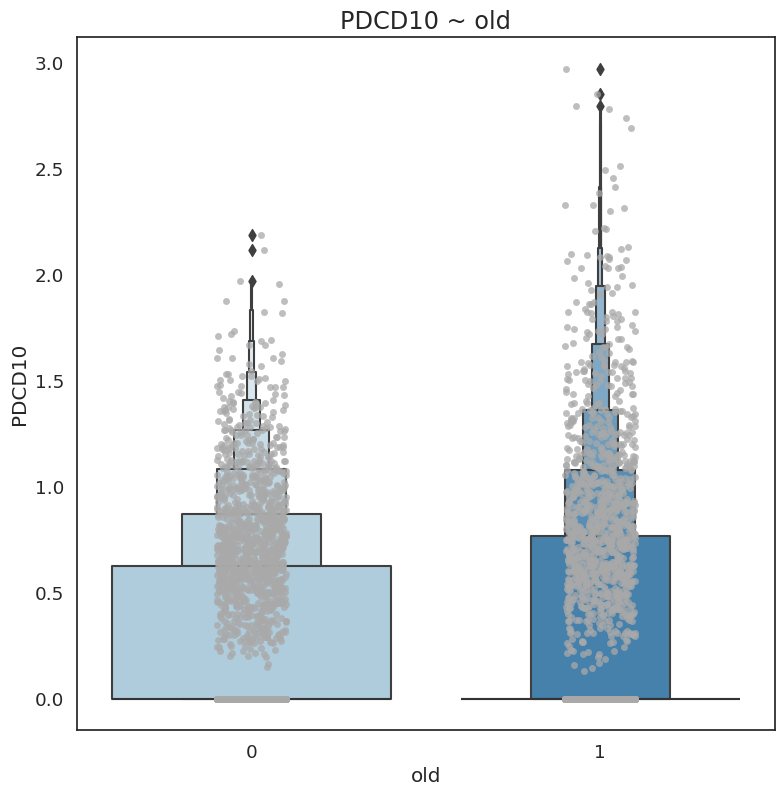

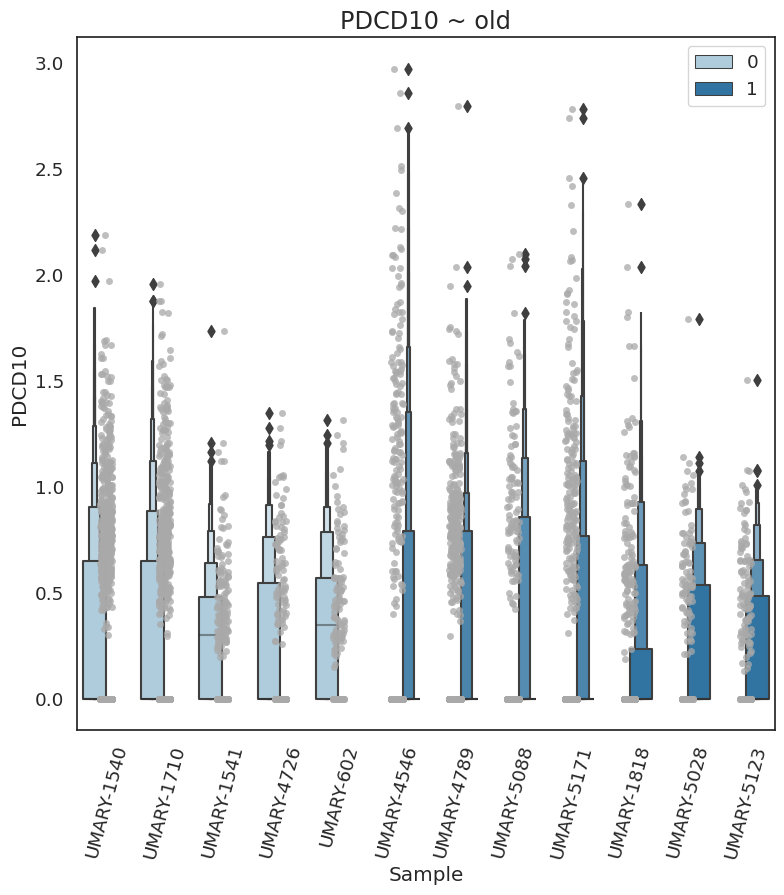

feature                     PDCD10
intercept                -1.197682
estimate                 -0.389955
std.error                 0.042263
statistic                -9.226864
p.value                        0.0
tissue          Frontal cortex InN
type         region_broad_celltype
fdr_bh                         0.0
Name: 7637, dtype: object


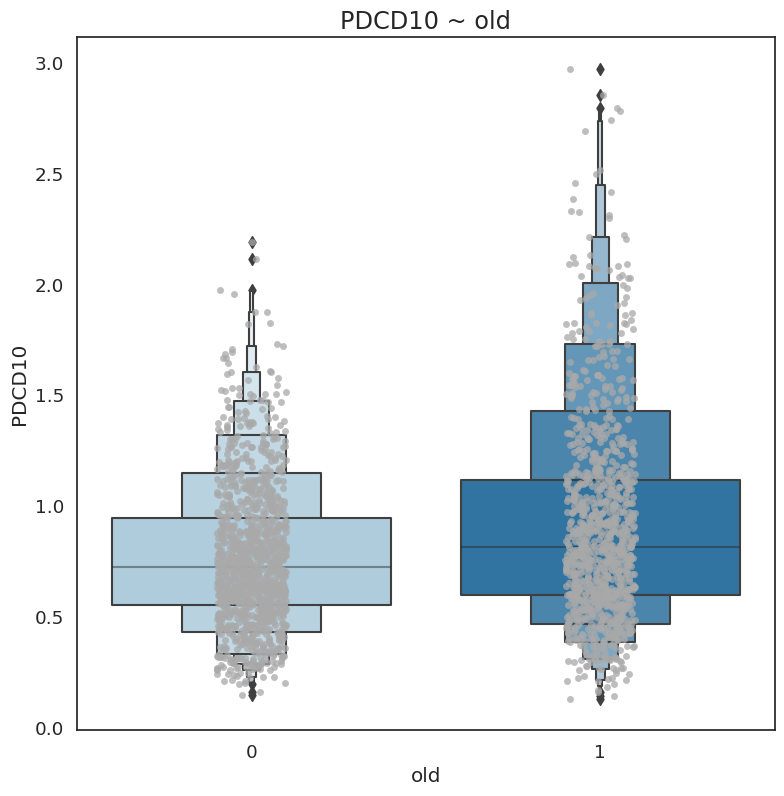

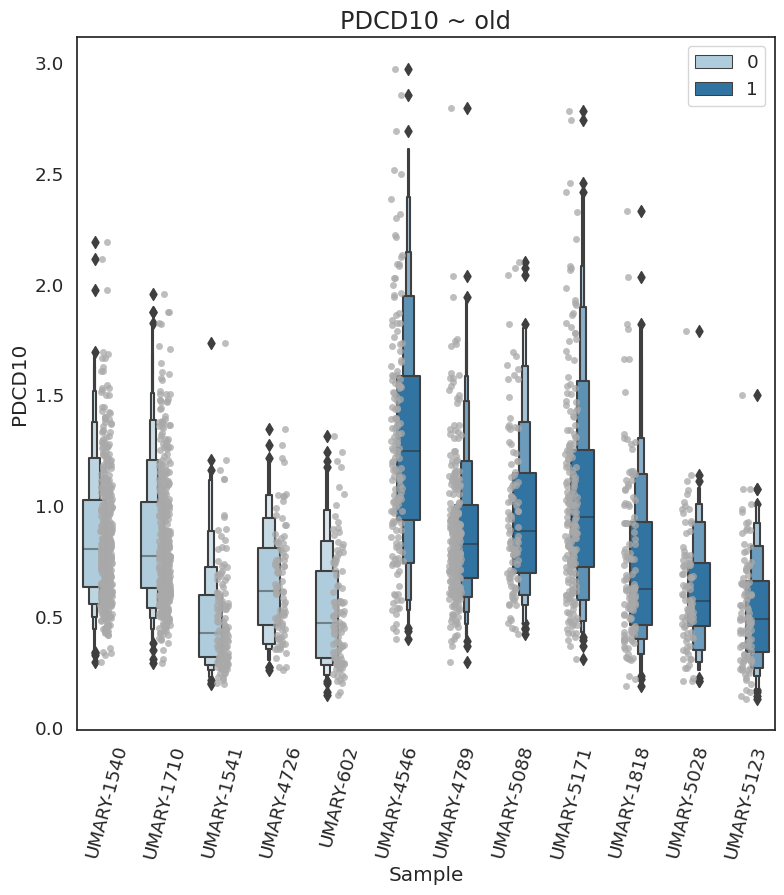

In [21]:
this_results = glmmtmb_results.loc[glmmtmb_results['p.value'] == min(glmmtmb_results['p.value'])]
this_hit = this_results.sort_values(by=['estimate'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

##### max significant by estimate (increasing)

feature                   C22orf34
intercept                 -4.98575
estimate                  2.865793
std.error                  0.76178
statistic                 3.761971
p.value                   0.000169
tissue        Frontal cortex Micro
type         region_broad_celltype
fdr_bh                    0.018149
Name: 64, dtype: object


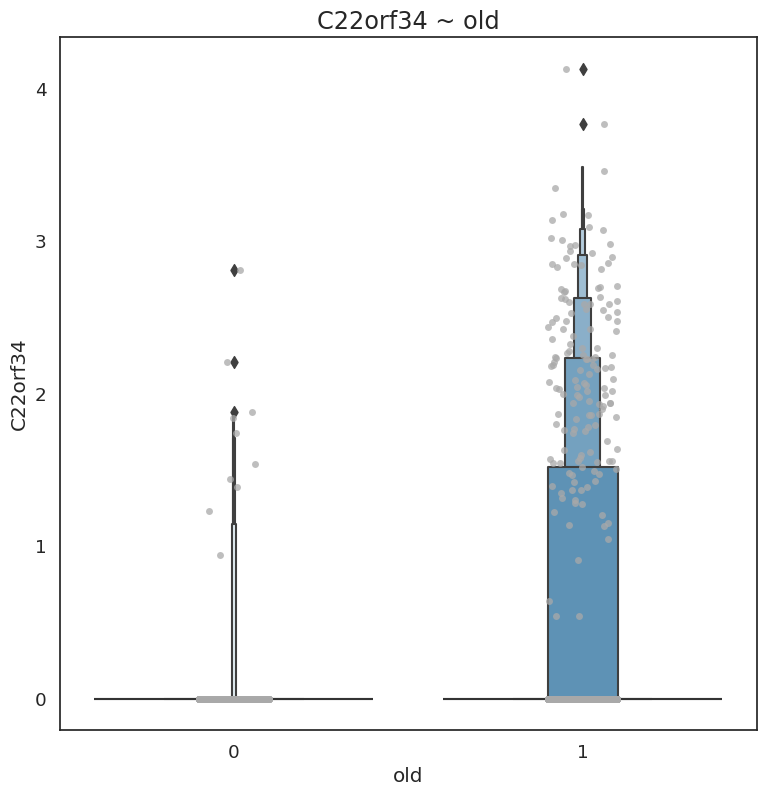

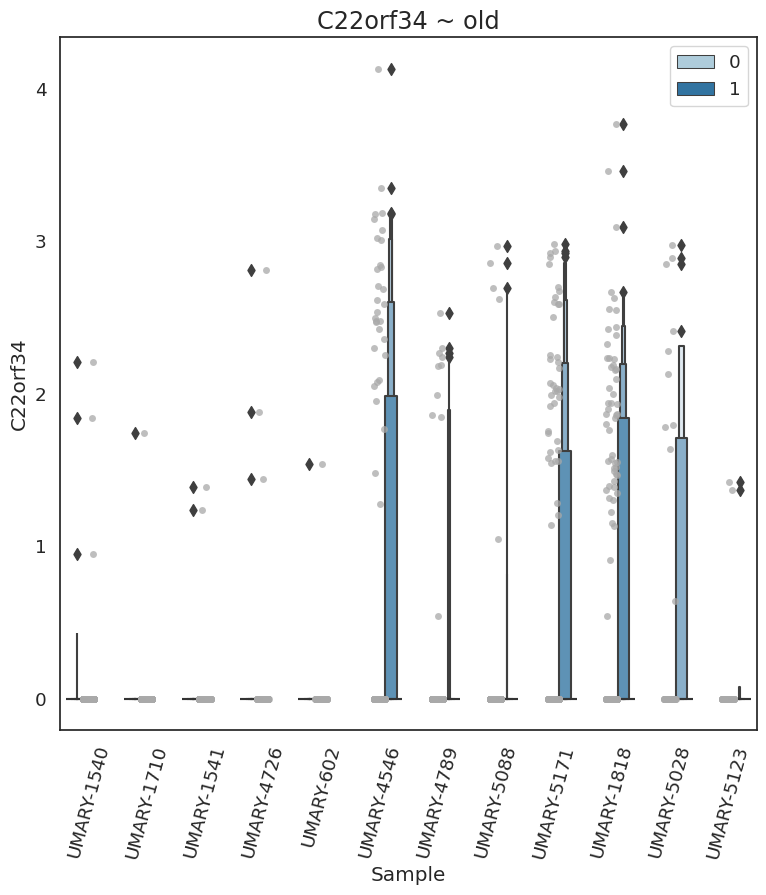

feature                   C22orf34
intercept                 -4.98575
estimate                  2.865793
std.error                  0.76178
statistic                 3.761971
p.value                   0.000169
tissue        Frontal cortex Micro
type         region_broad_celltype
fdr_bh                    0.018149
Name: 64, dtype: object


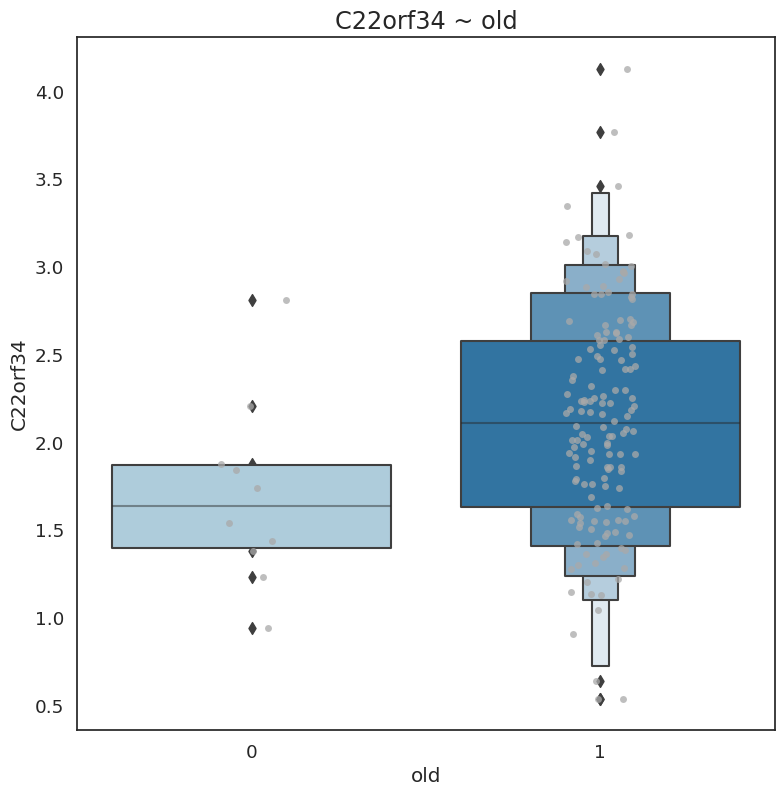

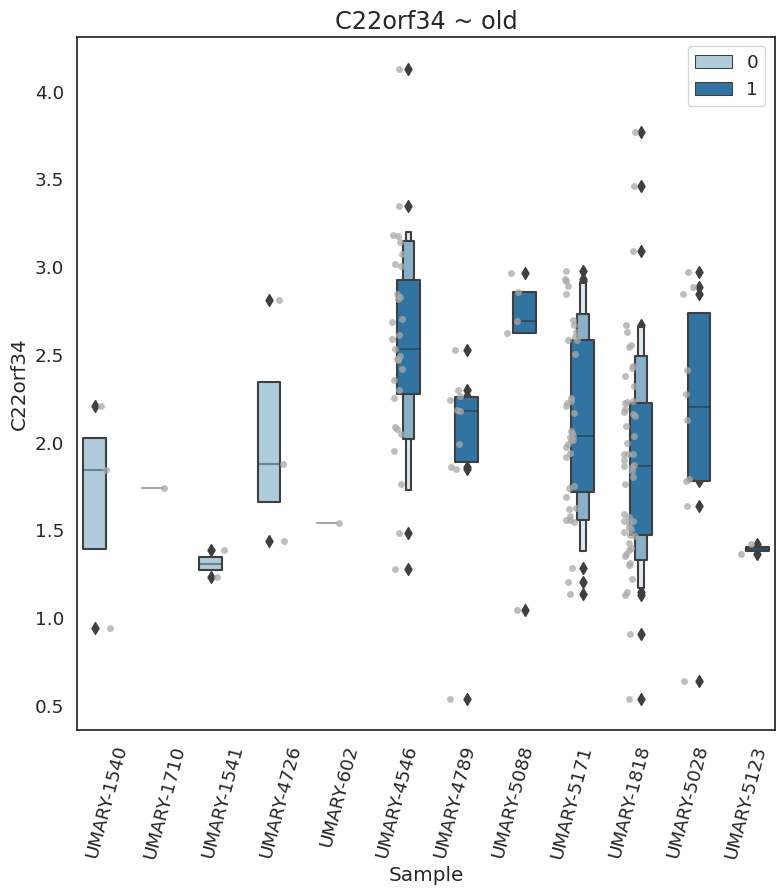

In [22]:
sig_results = glmmtmb_results.loc[glmmtmb_results['fdr_bh'] < 0.05]
this_results = sig_results.loc[sig_results['estimate'] == max(sig_results['estimate'])]
this_hit = this_results.sort_values(by=['estimate'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

##### random results

feature                      EEPD1
intercept                -0.966601
estimate                 -0.511558
std.error                 0.151371
statistic                -3.379504
p.value                   0.000726
tissue        Frontal cortex Micro
type         region_broad_celltype
fdr_bh                    0.045076
Name: 577, dtype: object


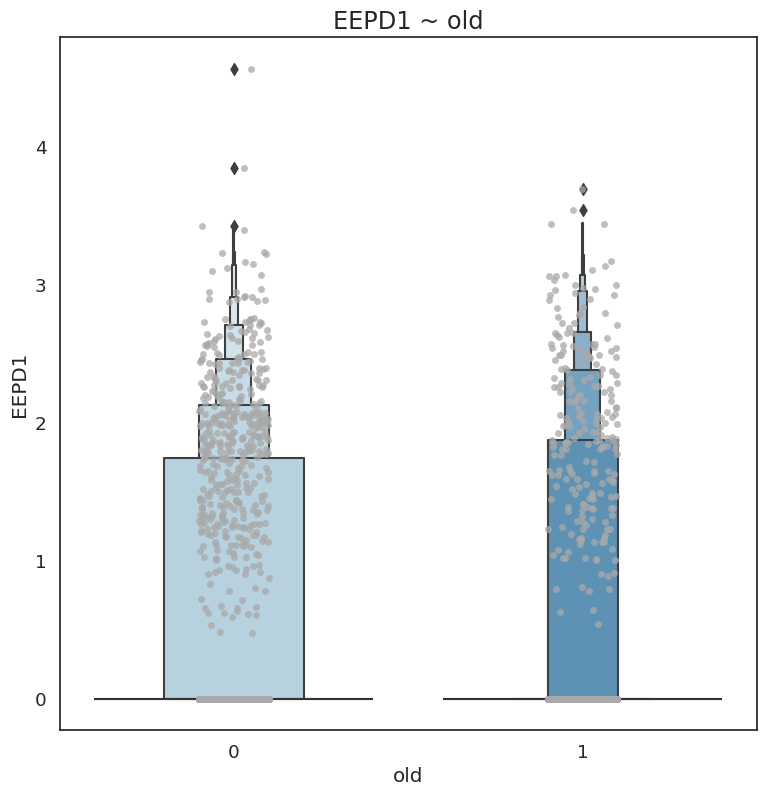

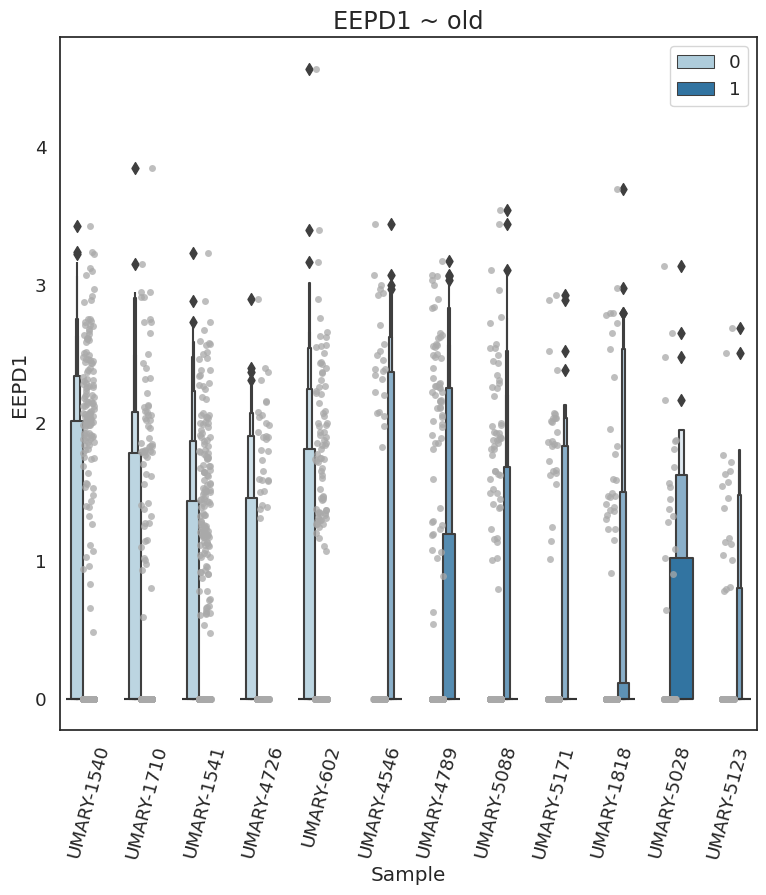

feature                      EEPD1
intercept                -0.966601
estimate                 -0.511558
std.error                 0.151371
statistic                -3.379504
p.value                   0.000726
tissue        Frontal cortex Micro
type         region_broad_celltype
fdr_bh                    0.045076
Name: 577, dtype: object


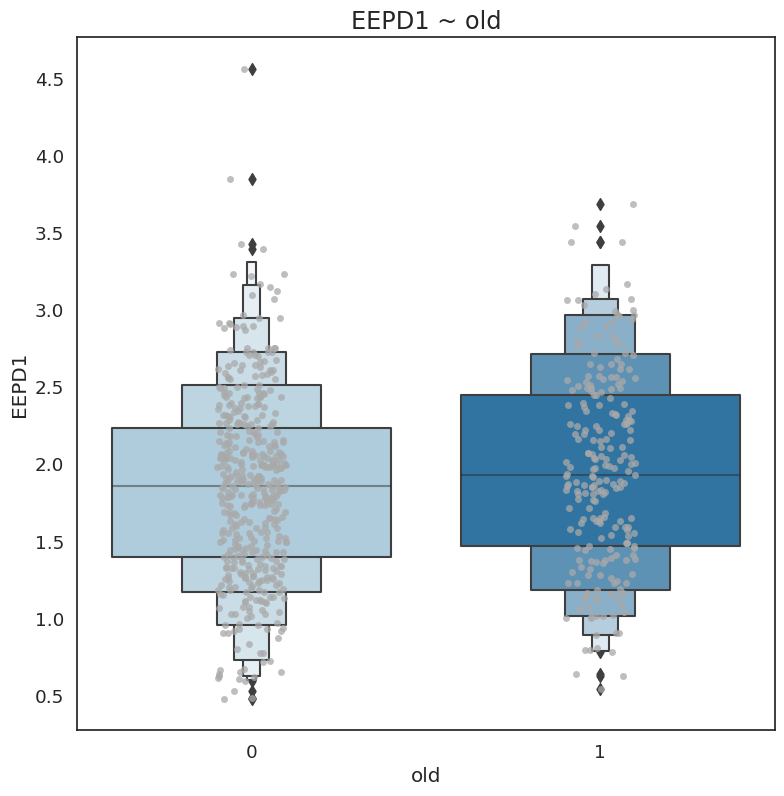

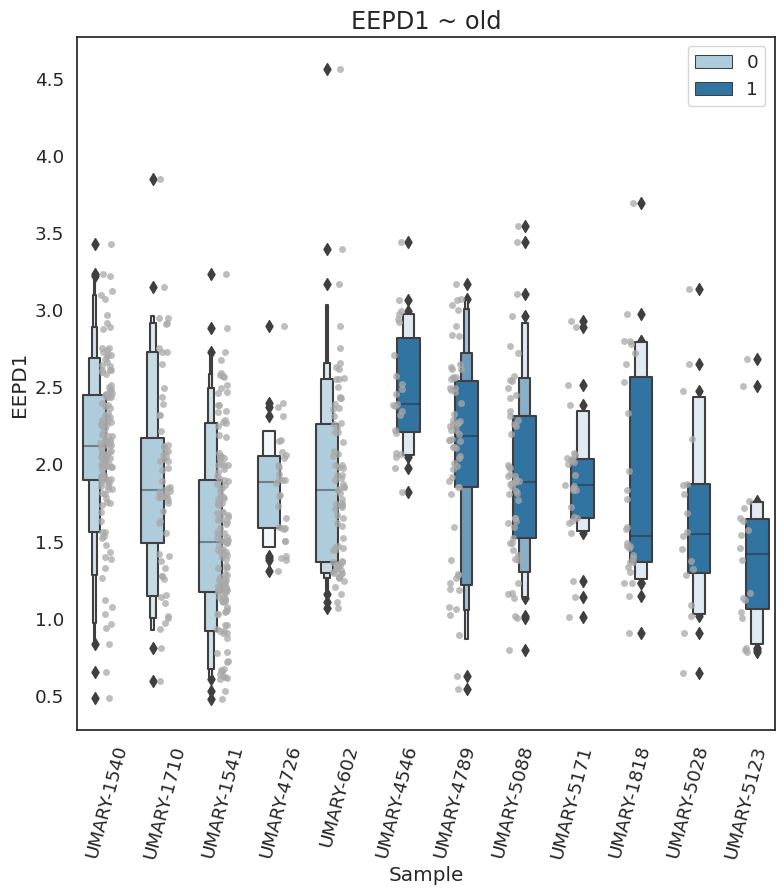

In [23]:
# random
this_hit = sig_results.sample().iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

##### max non-significat by coef (increasing)

feature                   ADAMTS18
intercept                -6.786338
estimate                  4.077891
std.error                 2.269781
statistic                 1.796601
p.value                   0.072399
tissue        Frontal cortex Oligo
type         region_broad_celltype
fdr_bh                     0.42109
Name: 7323, dtype: object


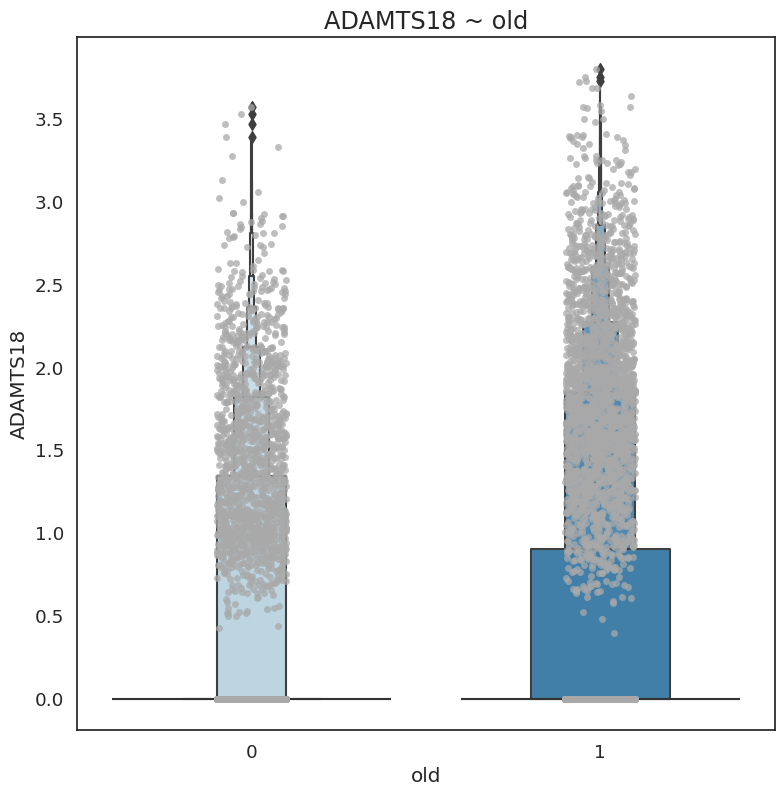

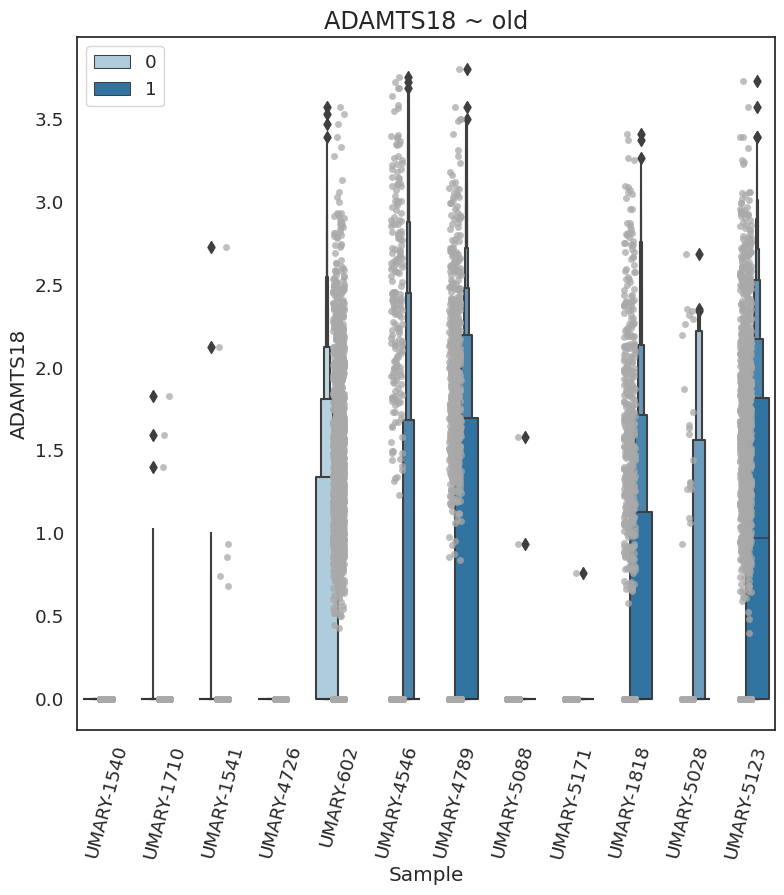

feature                   ADAMTS18
intercept                -6.786338
estimate                  4.077891
std.error                 2.269781
statistic                 1.796601
p.value                   0.072399
tissue        Frontal cortex Oligo
type         region_broad_celltype
fdr_bh                     0.42109
Name: 7323, dtype: object


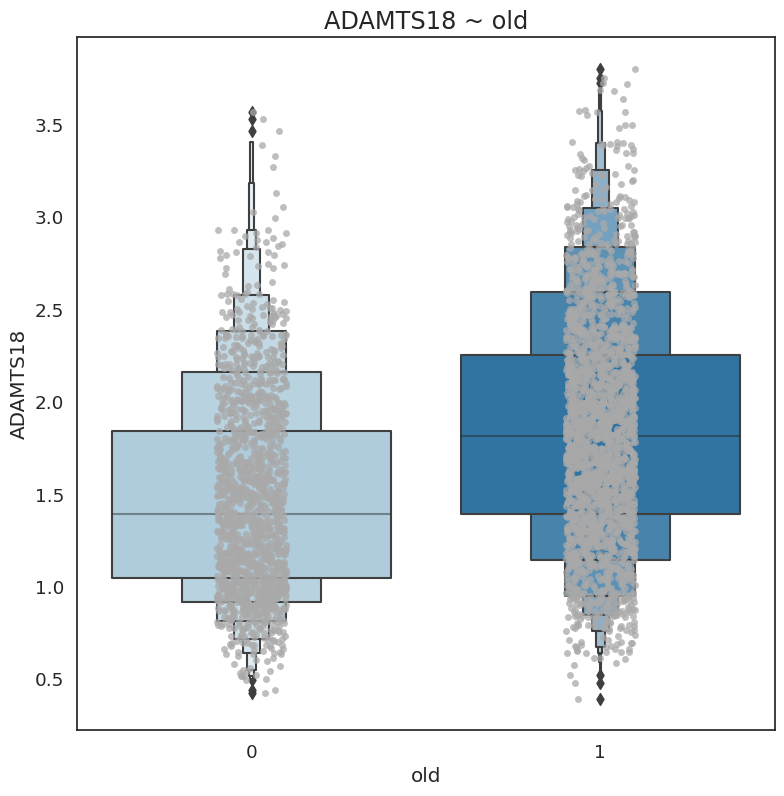

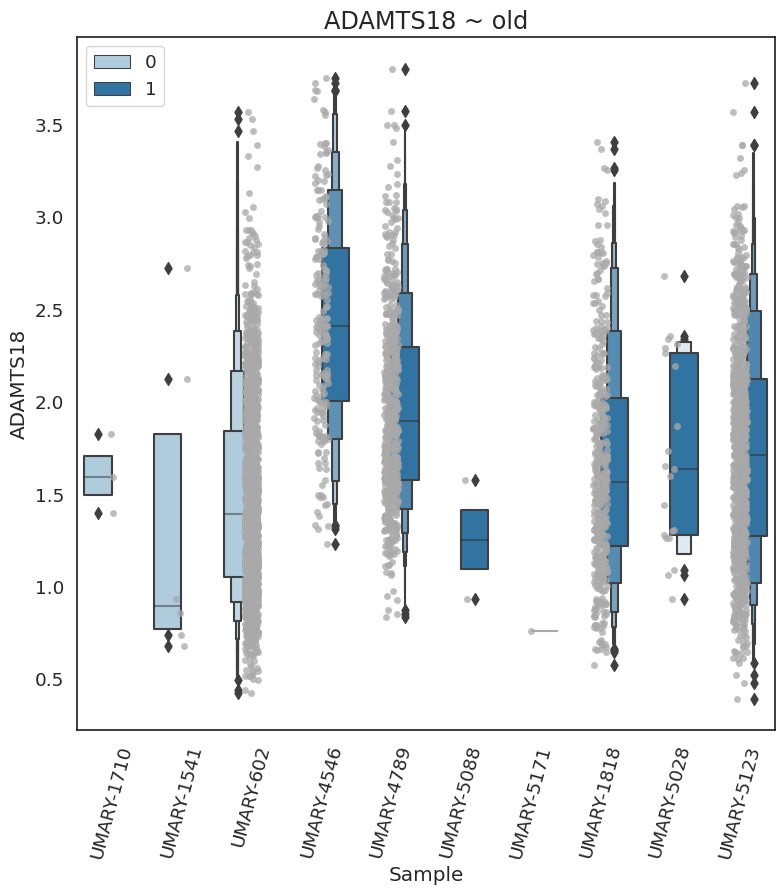

In [24]:
nonsig_results = glmmtmb_results.loc[(glmmtmb_results['fdr_bh'] > 0.05) & 
                                     (~glmmtmb_results['statistic'].isna())]
this_results = nonsig_results.loc[nonsig_results['estimate'] == max(nonsig_results['estimate'])]
this_hit = this_results.sort_values(by=['estimate'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

In [25]:
!date

Wed Jan  3 22:03:34 UTC 2024
